# Проектная работа: Отток клиентов

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Целью** данной проектной работы является разработка модели, которая могла бы успешно прогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

**Задачи** проекта заключаются в следующем:
1. Построении модели с большим значением F1-меры. **Минимальное** приемлемое значение F1-меры равняется 0.59.
2. Проверка F1-меры на тестовой выборке.
3. Подсчет AUC-ROC и сравнение её значения с F1-мерой.

**Описание данных**:
1. **Признаки**:
    - `RowNumber` - индекс строки в данных
    - `CustomerId` - уникальный идентификатор клиента
    - `Surname` - фамилия
    - `CreditScore` - кредитный рейтинг
    - `Geography` - страна проживания
    - `Gender` - пол
    - `Age` - возраст
    - `Tenure` - сколько лет человек является клиентом банка
    - `Balance` - баланс на счёте
    - `NumOfProducts` - количество продуктов банка, используемых клиентом
    - `HasCrCard` - наличие кредитной карты
    - `IsActiveMember` - активность клиента
    - `EstimatedSalary` - предполагаемая зарплата

2. **Целевой признак**:
    - `Exited` - факт ухода клиента

**План работы**:
1. Загрузка и подготовка данных.
2. Исследование баланса классов и обучение моделей без учёта дисбаланса.
3. Улучшение качества моделей благодаря снижению дисбаланса классов.
4. Выводы.

### Шаг 1. Загрузка и подготовка данных

##### 1.1. Просмотр данных

In [1]:
# импортируем необходимые библиотеки и модули
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, recall_score, precision_score, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

In [2]:
# загрузим данные
data = pd.read_csv("Churn.csv")
format_mapping = {"Tenure" : "{:.0f}", "Balance" : "{:,.2f}", "EstimatedSalary" : "{:,.2f}"}
data.head().style.format(format_mapping)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2,"125,510.82",1,1,1,"79,084.10",0


In [3]:
# посмотрим на размерность данных
data.shape

(10000, 14)

В данных содержатся 10 тыс. строк и 14 столбцов. 

In [4]:
# посмотрим названия столбцов
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
# проверим типы данных на соответствие описанию данных
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Типы данных в столбце в целом соответствуют описанию. Данные столбца `Tenure` можно поменять с `float64` на `int64`, потому что года считаются в целых числах.

In [6]:
# обощим ранее проверенные характеристики данных и посмотрим количество пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


#### Выводы:
<hr> 

С учетом того, что целевой признак `Exited` принимает два значения: `1` и `0`, необходимо решить задачу типа бинарной классификации. Модели, которые применимы для данной категории задачи, - это `DecisionTreeClassifier`, `RandomForestClassifier` и `LogisticRegression`. Также необходимо обработать пропуски в столбце `Tenure`, так как они составляют примерно `10%` от общего объема данных, проверить наличие дубликатов или нулевых и отрацительных значений в тех столбцах, где их не должно быть. Возможно, между количественными признаками есть линейные связи, что также необходимо проверить.

##### 1.2. Предобработка данных

##### 1.2.1. Заполнение пропусков

В столбце `Tenure` есть пропуски, которые составляют примерно 10% от общего объема данных. Странно, что в таком столбце вообще есть пропуски, потому что банк должен фиксировать, с какой даты были установлены деловые отношения с клиентом. Возможно, это давние клиенты банка, поэтому часть данных по ним утеряна.

Были рассмотрены разные варианты заполнения пропусков:
- заполнение медианным значением на основе группированных данных;
- заполнение случайным числом от 0 до 10;
- заполнение нулями.

Однако первые два варианта привели к укрупнению данных вокруг одного значения, что искажает распределение значений в данном столбце. Поэтому был принят третий вариант: мы будем считать клиентов, по которым значение `Tenure` пропущено, новыми, то есть с ними только в этом году были установлены деловые отношения.

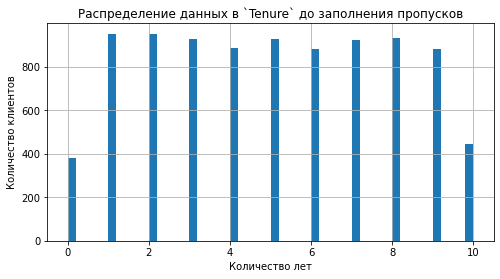

In [7]:
# посмотрим распределение в столбце `Tenure` до заполнения пропусков
plt.figure(figsize = (8, 4))
data["Tenure"].hist(bins = 50)
plt.title("Распределение данных в `Tenure` до заполнения пропусков")
plt.xlabel("Количество лет")
plt.ylabel("Количество клиентов")
plt.show()

In [8]:
# заполним пропуски нулями
data["Tenure"] = data["Tenure"].fillna(0)
print("Количество пропусков в столбце Tenure:", data["Tenure"].isna().sum())

Количество пропусков в столбце Tenure: 0


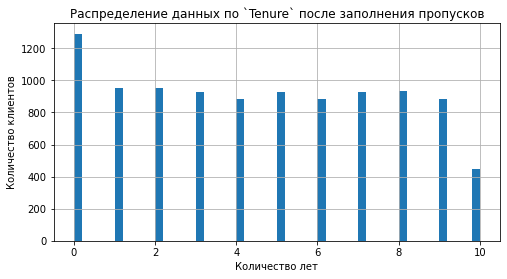

In [9]:
# посмотрим распределение в столбце `Tenure` после заполнения пропусков
plt.figure(figsize = (8, 4))
data["Tenure"].hist(bins = 50)
plt.title("Распределение данных по `Tenure` после заполнения пропусков")
plt.xlabel("Количество лет")
plt.ylabel("Количество клиентов")
plt.show()

##### 1.2.2. Наличие дубликатов в данных

Наличие дубликатов проверим в целом по таблице с данными, а не по столбцам. В конкретных столбцах могут быть дубликаты, но это не значит, что есть ошибка во всей строке.

In [10]:
# проверим количество дублирующих строк в данных
print("Количество дубликатов в данных:", data.duplicated().sum())

Количество дубликатов в данных: 0


##### 1.2.3. Наличие нулевых или отрицательных значений

В некоторых столбцах априори не могут быть нулевые или отрицательные значения, поэтому нужно убедиться, что это действительно так. В случае обнаружения таких значений, нужно исправить их.

Итак, мы не ожидаем увидеть нулевые или отрицательные значения в следующих столбцах:
- CustomerId
- CreditScore
- Age

Нулевые значения могут быть в следующих столбцах, но без отрицательных значений:
- Tenure
- Balance
- NumOfProducts
- EstimatedSalary

В остальных столбцах мы не ожидаем ошибок, так как они представляют категориальные признаки клиентов банка.

In [11]:
first_column_group = ["CustomerId", "CreditScore", "Age"]

for col in first_column_group:
    print(f"Наличие нулевых или отрицательных значений в колонке {col}: {any(data[col].unique() <= 0)}")

Наличие нулевых или отрицательных значений в колонке CustomerId: False
Наличие нулевых или отрицательных значений в колонке CreditScore: False
Наличие нулевых или отрицательных значений в колонке Age: False


In [12]:
second_column_group = ["Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]

for col in second_column_group:
    print(f"Наличие отрицательных значений в колонке {col}: {any(data[col].unique() < 0)}")

Наличие отрицательных значений в колонке Tenure: False
Наличие отрицательных значений в колонке Balance: False
Наличие отрицательных значений в колонке NumOfProducts: False
Наличие отрицательных значений в колонке EstimatedSalary: False


##### 1.2.4. Наличие лишней колонки в данных

Столбец `RowNumber` представляет собой индекс строки в данных. Его можно было бы указать как индекс в наборе данных при считывании. Однако индексация в этом столбце начинается с `1`, а не с `0`, как это принято в *Python*. Чтобы не сбиться с индексацией, оставим индексацию, принятую в *Python*, поэтому столбец `RowNumber` можно удалить из данных.

Помимо этого, столбцы `CustomerId` и `Surname` скорее всего были созданы для быстрого поиска информации по клиентам банкам. Для целей обучения моделей они не играют никакой роли, поэтому их также удалим из набора данных.

In [13]:
data = data.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)
data.head().style.format(format_mapping)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,"101,348.88",1
1,608,Spain,Female,41,1,"83,807.86",1,0,1,"112,542.58",0
2,502,France,Female,42,8,"159,660.80",3,1,0,"113,931.57",1
3,699,France,Female,39,1,0.00,2,0,0,"93,826.63",0
4,850,Spain,Female,43,2,"125,510.82",1,1,1,"79,084.10",0


##### 1.2.5. Наличие линейной связи между признаками

Мы ожидаем, что между количественными признаками в данных могут линейные связи, поэтому проверим данное предположение, построив корреляционную дтаграмму.

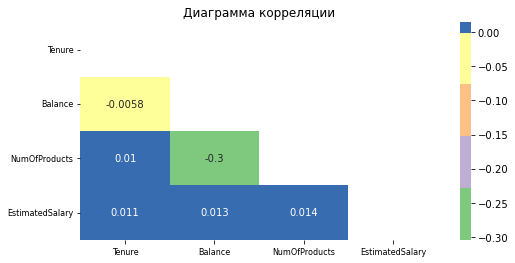

In [14]:
correlation = data[["Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]].corr()

triangle = np.triu(correlation)

plt.figure(figsize = (8, 4))

sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, cmap = "Accent", center = 0, annot = True, mask = triangle)

plt.title('Диаграмма корреляции', fontsize = 12)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

### Выводы
---
В результате проверок критические недостатки в данных не обнаружены. Пропуски в столбце `Tenure` заполнены. Качество предоставленных данных оцивается как высокое.

### Шаг 2. Исследование баланса классов и обучение моделей без учёта дисбаланса

##### 2.1. Подготовка признаков

Наличие категориальных признаков приводит к ошибкам в алгоритмах, предназначенных для задачи классификации. Поэтому преобразуем категориальные признаки в численные с помощью техники прямого кодирования. При этом, чтобы не попасть в ловушку фиктивных признаков, удалим один из столбцов, которые добавляются в исходную таблицу в результате применения техники прямого кодирования.

In [15]:
data_ohe = pd.get_dummies(data, drop_first = True)
data_ohe.head().style.format(format_mapping)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,"101,348.88",1,0,0,0
1,608,41,1,"83,807.86",1,0,1,"112,542.58",0,0,1,0
2,502,42,8,"159,660.80",3,1,0,"113,931.57",1,0,0,0
3,699,39,1,0.00,2,0,0,"93,826.63",0,0,0,0
4,850,43,2,"125,510.82",1,1,1,"79,084.10",0,0,1,0


Разброс в признаках с количественным значением может быть достаточно велик, из-за какой-нибудь признак будет расценен моделью более важным по сравнению с остальными, хотя все признаки одинаково значими. Устранить такое неравенство можно с помощью стандартизации данных.

In [16]:
features = data_ohe.drop("Exited", axis = 1)
target = data_ohe["Exited"]

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.25, random_state = 12345
)

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric])

features_train[numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid[numeric] = scaler.transform(features_valid.loc[:, numeric])

processed_data = pd.concat([features_train, features_valid])
processed_data.head().style.format(format_mapping)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
226,0.442805,-0.841274,1,-1.22,0.817772,1,1,-1.27,0,0,0
7756,-0.310897,-0.270730,1,0.64,-0.896874,1,1,0.96,0,1,0
2065,-0.259274,-0.556002,1,-1.22,0.817772,1,0,0.66,0,0,1
2800,1.217157,1.155631,1,1.29,0.817772,1,0,-1.04,0,0,1
7028,0.690598,-1.221637,-1,1.14,-0.896874,0,0,-0.85,1,0,1


Обратно собираем таблицу целиком после всех манипуляций.

In [17]:
processed_data = pd.concat([processed_data, data_ohe["Exited"]], axis = 1)
print(processed_data.shape)

(10000, 12)


##### 2.2. Разделение данных на обучающую, валидационную и тестовую выборки

Разделим набор данных на обучающую, валидационную и тестирующую выборки.

In [18]:
# 60% данных - обучающая выборка
df_train, temp = train_test_split(processed_data, test_size = 0.4, random_state = 12345)
# валидационная и тестовые выборки - по 20% от всех данных
df_valid, df_test = train_test_split(temp, test_size = 0.5, random_state = 12345)

print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(6000, 12)
(2000, 12)
(2000, 12)


In [19]:
features_train = df_train.drop(["Exited"], axis = 1)
target_train = df_train["Exited"]

features_valid = df_valid.drop(["Exited"], axis = 1)
target_valid = df_valid["Exited"]

features_test = df_test.drop(["Exited"], axis = 1)
target_test = df_test["Exited"]

##### 2.3. Обучение моделей без учета дисбаланса

##### Дерево решений

In [20]:
best_model = None
best_accuracy = 0
max_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(predictions, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        max_depth = depth
 
print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Максимальная глубина лучшей модели: {max_depth}", sep = "\n")

Качество лучшей модели: 0.847
Максимальная глубина лучшей модели: 6


##### Алгоритм случайного леса

In [21]:
best_model = None
best_accuracy = 0
best_est = 0

for est in range(10, 201, 10):
    model = RandomForestClassifier(random_state = 12345, n_estimators = est)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_est = est

print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Число деревьев в лучшей модели: {best_est}", sep = "\n")

Качество лучшей модели: 0.854
Число деревьев в лучшей модели: 190


##### Логистическая регрессия

In [22]:
best_model = None
best_accuracy = 0
best_iter = 0

for iter in range(100, 1001, 50):
    model = LogisticRegression(random_state = 12345, solver = "lbfgs", max_iter = iter)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_iter = iter

print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Максимальное количество итераций: {best_iter}", sep = "\n")

Качество лучшей модели: 0.7985
Максимальное количество итераций: 100


На обучающей выборке самой качественной оказалась модель, построенная на алгоритме случайного леса. Ее качество составило 0.854, а количество деревьев - 190.

##### 2.4. Тестирование алгоритма случайного леса

In [23]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 190) 
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
accuracy_valid = accuracy_score(target_test, predicted_valid)
print(f"Качество модели: {accuracy_valid.round(4)}")

Качество модели: 0.8705


На тестовой выборке лучшая модель, выявленная в ходе обучения, продемонстрировала еще более высокий результат. Ее качество составило 0.8705.

##### 2. 5. Исследование баланса классов

В исходных данных наблюдается сильный дисбаланс классов. В целевом признаке практически 80% отрицательных значений, то есть 80% клиентов банка еще не ушли от него. Поэтому их нужно удержить, а для этого нужна модель, которая с высокой долей вероятности сможет предсказать, уйдет ли клиент банка.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

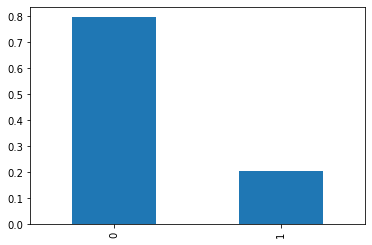

In [24]:
class_frequency = processed_data["Exited"].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind = "bar")

В своих прогнозах на тестовой выборке выбранная нами модель предсказала, что практически 88% клиента не уйдут от банка.

0    0.8755
1    0.1245
dtype: float64


<AxesSubplot:>

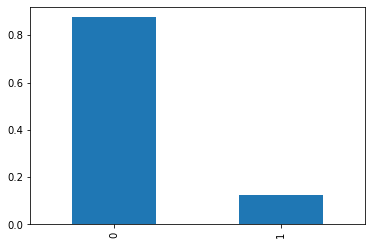

In [25]:
predicted_valid = pd.Series(predicted_valid)
class_frequency = predicted_valid.value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind = "bar")

Если заменить модель столбцом, состоящим из одних нулей, качество такой модели тоже окажется достаточно высокой. Поэтому выбранная нами модель пока что не пригодна для применения на практике, то есть проверку на адекватность она не прошла.

In [26]:
target_pred_constant = pd.Series(0, index = target.index)
accuracy = accuracy_score(target, target_pred_constant)
print(accuracy)

0.7963


##### 2.6. Метрики классификации

Тем не менее, посчитаем метрики классификации. В матрице ошибок видим, что достаточно большое количество наблюдений модель классифицирует как 0, хотя на самом деле они принимают значения 1 (*False Negative* = 210).

In [27]:
confusion_matrix(target_test, predicted_valid)

array([[1541,   49],
       [ 210,  200]])

Метрика *recall* показывает, что наша модель выделила практически половину положительных ответов среди всех ответов.

In [28]:
print("Значение метрики recall:", "{:,.2%}".format(recall_score(target_test, predicted_valid)))

Значение метрики recall: 48.78%


Метрика *precision* показывает, что 80% наблюдений, отмеченных моделью как положительные, действительно являются таковыми.

In [29]:
print("Значение метрики precision:", "{:,.2%}".format(precision_score(target_test, predicted_valid)))

Значение метрики precision: 80.32%


А гармоническое среднее *recall* и *precision* равняется 60.70%.

In [30]:
print("Значение F1-меры:", "{:,.2%}".format(f1_score(target_test, predicted_valid)))

Значение F1-меры: 60.70%


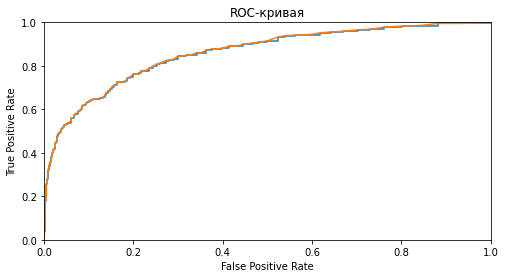


Значение метрики ROC-AUC: 86.08%


In [31]:
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_valid[:, 1])
fpr, tpr, threshold = roc_curve(target_test, probabilities_one_valid)
plt.figure(figsize = (8, 4))
plt.step(fpr, tpr, where = 'post')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print()
print("Значение метрики ROC-AUC:", "{:,.2%}".format(roc_auc_score(target_test, probabilities_one_valid)))

### Шаг 3. Улучшение качества моделей благодаря увеличению выборки

##### 3.1. Увеличение выборки

Дисбаланс классов можно поправить, применив технику upsampling. Мы искуственно увеличим долю положительного класса в целевом признаке в обучающей выборке, чтобы модель качественнее научилась определять его.

In [32]:
print(features_train.shape)
print(target_train.shape)

(6000, 11)
(6000,)


In [33]:
def upsample(features, target, repeat = 4):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_unsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    return shuffle(features_upsampled, target_unsampled, random_state = 12345)

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9651, 11)
(9651,)


##### 3.2. Обучение моделей на увеличенной выборке

Начнем поиск наилучшей модели на расширенной тестовой выборке.

##### Дерево решений

In [34]:
best_model = None
best_accuracy = 0
max_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(predictions, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        max_depth = depth
 
print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Максимальная глубина лучшей модели: {max_depth}", sep = "\n")

Качество лучшей модели: 0.757
Максимальная глубина лучшей модели: 7


##### Алгоритм случайного леса

In [35]:
best_model = None
best_accuracy = 0
best_est = 0

for est in range(10, 201, 10):
    model = RandomForestClassifier(random_state = 12345, n_estimators = est)
    model.fit(features_upsampled, target_upsampled)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_est = est

print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Число деревьев в лучшей модели: {best_est}", sep = "\n")

Качество лучшей модели: 0.847
Число деревьев в лучшей модели: 150


##### Логистическая регрессия

In [36]:
best_model = None
best_accuracy = 0
best_iter = 0

for iter in range(100, 1001, 50):
    model = LogisticRegression(random_state = 12345, solver = "lbfgs", max_iter = iter)
    model.fit(features_upsampled, target_upsampled)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_iter = iter

print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Максимальное количество итераций: {best_iter}", sep = "\n")

Качество лучшей модели: 0.7055
Максимальное количество итераций: 100


В результате поиска лучшей осталась модель, построенная на алгоритме случайного леса. Число деревьев стало меньше на 40 до 150, и качество незначительно снизилось. Стоит отметить существенное снижение качеств моделей, построенных на алгоритме решающего дерева (0.757 с максимальной грубиной 7) и логистической регрессии (0.7055 с максимальным количеством итераций 100). 

##### 3.3. Тестирование алгоритма случайного леса

In [37]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 150) 
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_test)
accuracy_valid = accuracy_score(target_test, predicted_valid)
print(f"Качество модели: {accuracy_valid.round(4)}")

Качество модели: 0.858


На тестовой выборке алгоритм случайного леса также показал высокий результат.

##### 3.4. Метрики классификации

В результате применения техники upsampling модель начала лучше определять положительные наблюдения в целевом признаке. Количество ложноотрицательных ответов уменьшилось, однако выросло число ложноположительных ответов. 

In [38]:
confusion_matrix(target_test, predicted_valid)

array([[1487,  103],
       [ 181,  229]])

Теперь модель корректно определила чуть больше половины положительных наблюдей в целевом признаке. Ранее доля таких ответов составляла меньше чем половина наблюдений.

In [39]:
print("Значение метрики recall:", "{:,.2%}".format(recall_score(target_test, predicted_valid)))

Значение метрики recall: 55.85%


Параллельно с этим снизилась доля корректно отмеченных моделью положительных ответов.

In [40]:
print("Значение метрики precision:", "{:,.2%}".format(precision_score(target_test, predicted_valid)))

Значение метрики precision: 68.98%


Среднее гармоническое *recall* и *precision* увеличилась до 62%.

In [41]:
print("Значение F1-меры:", "{:,.2%}".format(f1_score(target_test, predicted_valid)))

Значение F1-меры: 61.73%


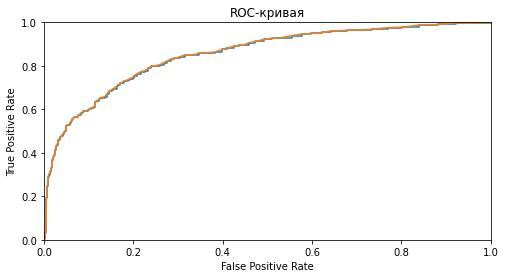


Значение метрики ROC-AUC: 85.67%


In [42]:
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_valid[:, 1])
fpr, tpr, threshold = roc_curve(target_test, probabilities_one_valid)
plt.figure(figsize = (8, 4))
plt.step(fpr, tpr, where = 'post')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print()
print("Значение метрики ROC-AUC:", "{:,.2%}".format(roc_auc_score(target_test, probabilities_one_valid)))

### Выводы
---
С увеличением выборки мы получили более качественную модель с улучшенными результатами.

### Шаг 4. Улучшение качества моделей благодаря уменьшению выборки

##### 4.1. Метод уменьшения выборки

In [43]:
print(features_train.shape)
print(target_train.shape)

(6000, 11)
(6000,)


In [44]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac = fraction, random_state = 12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac = fraction, random_state = 12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state = 12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2413, 11)
(2413,)


##### 4.2. Обучение моделей на уменьшенной выборке

##### Дерево решений

In [45]:
best_model = None
best_accuracy = 0
max_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model.fit(features_downsampled, target_downsampled)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(predictions, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        max_depth = depth
 
print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Максимальная глубина лучшей модели: {max_depth}", sep = "\n")

Качество лучшей модели: 0.75
Максимальная глубина лучшей модели: 6


##### Алгоритм случайного леса

In [46]:
best_model = None
best_accuracy = 0
best_est = 0

for est in range(10, 201, 10):
    model = RandomForestClassifier(random_state = 12345, n_estimators = est)
    model.fit(features_downsampled, target_downsampled)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_est = est

print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Число деревьев в лучшей модели: {best_est}", sep = "\n")

Качество лучшей модели: 0.7715
Число деревьев в лучшей модели: 10


##### Логистическая регрессия

In [47]:
best_model = None
best_accuracy = 0
best_iter = 0

for iter in range(100, 1001, 50):
    model = LogisticRegression(random_state = 12345, solver = "lbfgs", max_iter = iter)
    model.fit(features_downsampled, target_downsampled)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_iter = iter

print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Максимальное количество итераций: {best_iter}", sep = "\n")

Качество лучшей модели: 0.7065
Максимальное количество итераций: 100


Первое, что бросается в глаза, глядя на полученные результаты, - это то, что качество каждой модели стало заметно ниже. В результате обучения на уменьшенной выборке лучшей моделью снова стала построенная на алгоритме случайного леса, хотя и разница с алгоритмом решающего дерева небольшая.

##### 4.3. Тестирование модели на алгоритме случайного леса

In [48]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 10)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_test)
accuracy_valid = accuracy_score(target_test, predicted_valid)
print(f"Качество модели: {accuracy_valid.round(4)}")

Качество модели: 0.779


На тестовой выборке качество немного улучшилось. Корректную оценку модели получим, рассчитав метрики классификации.

##### 4.4. Метрики классификации

В результате применения техники downsampling модель начала лучше определять положительные наблюдения в целевом признаке. Баланс между ложноположительными и ложноотрицательными ответами развернулся в обратную сторону, то есть ложноотрицательных ответов стало намного больше.

In [49]:
confusion_matrix(target_test, predicted_valid)

array([[1268,  322],
       [ 120,  290]])

Теперь модель корректно определяет практически 71% положительных наблюдей в целевом признаке. Ранее доля таких ответов составляла чуть больше половины наблюдений.

In [50]:
print("Значение метрики recall:", "{:,.2%}".format(recall_score(target_test, predicted_valid)))

Значение метрики recall: 70.73%


Параллельно с этим снизилась доля корректно отмеченных моделью положительных ответов.

In [51]:
print("Значение метрики precision:", "{:,.2%}".format(precision_score(target_test, predicted_valid)))

Значение метрики precision: 47.39%


Однако среднее гармоническое *recall* и *precision* оказалось только 56.75%, что ниже целевого значения в 59%.

In [52]:
print("Значение F1-меры:", "{:,.2%}".format(f1_score(target_test, predicted_valid)))

Значение F1-меры: 56.75%


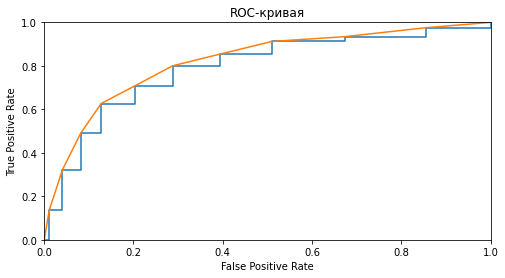


Значение метрики ROC-AUC: 82.18%


In [53]:
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_valid[:, 1])
fpr, tpr, threshold = roc_curve(target_test, probabilities_one_valid)
plt.figure(figsize = (8, 4))
plt.step(fpr, tpr, where = 'post')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print()
print("Значение метрики ROC-AUC:", "{:,.2%}".format(roc_auc_score(target_test, probabilities_one_valid)))

### Шаг 5. Выводы
---
Таким образом, в данной работе был исследован баланс классов, и были обучены модели без учета дисбаланса. Затем баланс классов был исправлен благодаря увеличению и уменьшению выборок, а модели - обучены снова.

Модель, полученная в результате проделанной работы, построена на алгоритме случайного леса со 150 деревьями. Дисбаланс классов вносил существенный вклад на работу модели. Так, она давала отрицательные ответы в 9 из 10 наблюдений. В связи с этим необходимо было митигировать последствия классового дисбаланса, чтобы получить более корректные ответы от модели. В результате применения метода увеличения выборки метрики классификации получились приемлемыми. Полученная модель научилась корректно определять чуть больше половины положительных наблюдей в целевом признаке, а f1-мера равняется 61.73%.

С другой стороны, метод уменьшения выборки привел к ухудшению метрик классификации. F1-мера упала до 56.75%.